In [97]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [98]:
# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [99]:
# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")


Total number of '1' images in the training set: 6742


Shape of the flattened image: torch.Size([784])


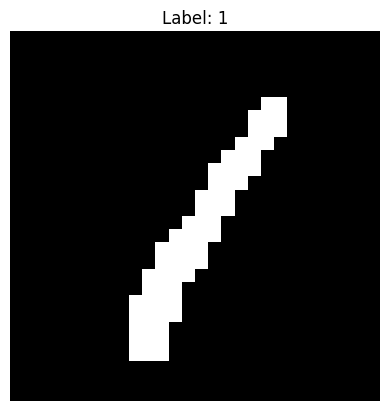

In [100]:
# Retrieve one sample from the filtered dataset
sample_img, sample_label = mnist_train_ones[0]

print("Shape of the flattened image:", sample_img.shape)  # Should be [784]

# Reshape back to 28x28 for visualization
img_reshaped = sample_img.view(28, 28)

plt.imshow(img_reshaped, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()


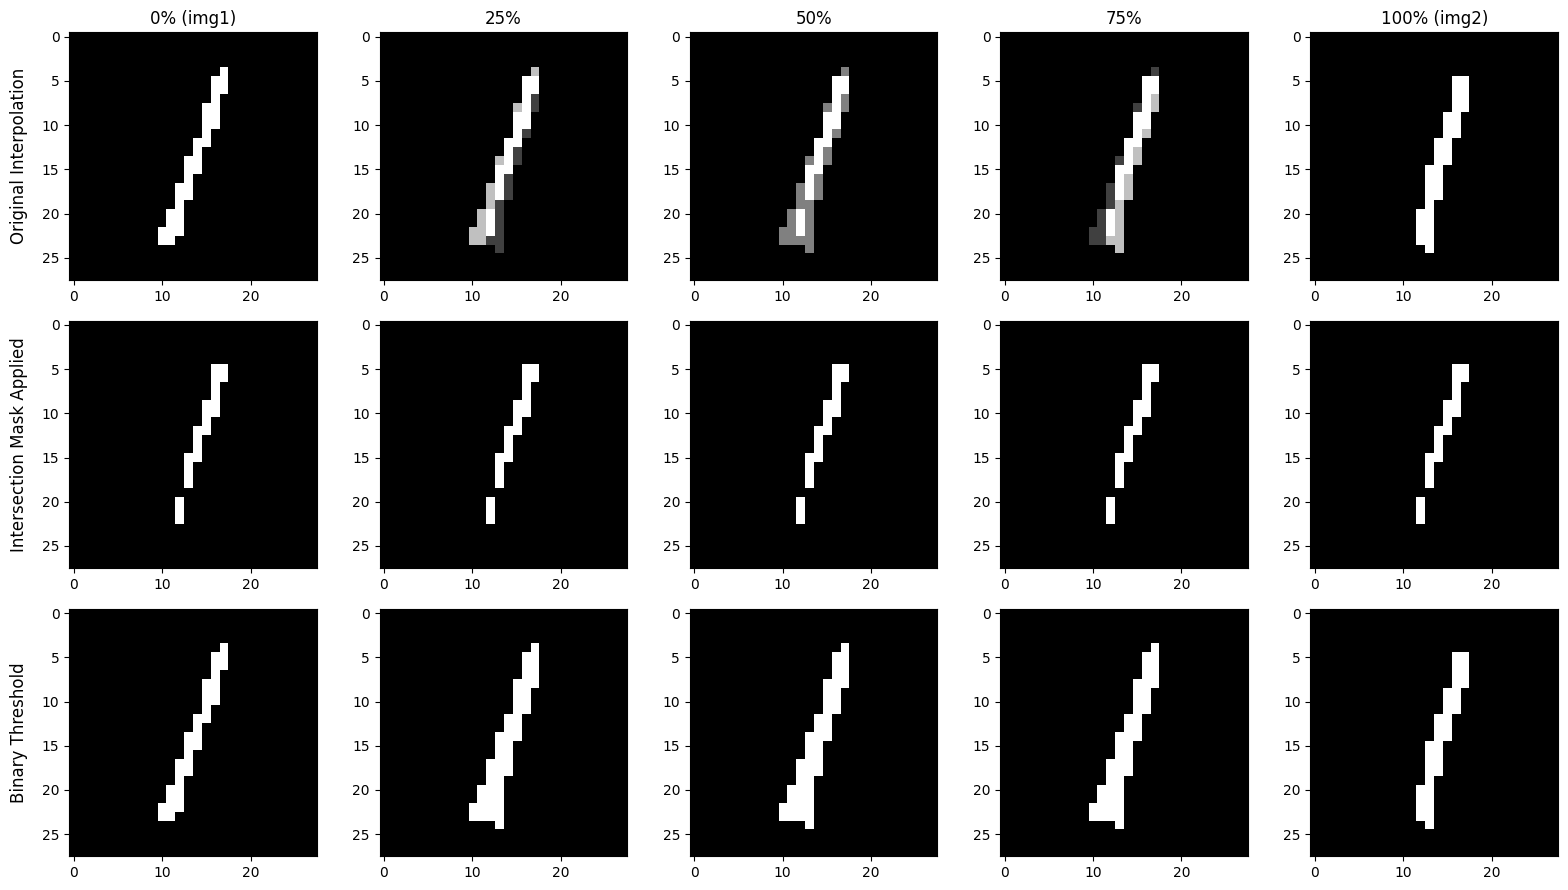

In [101]:
import random
import matplotlib.pyplot as plt

# Randomly sample two images from the filtered dataset of 1s
idx1 = random.randint(0, len(mnist_train_ones) - 1)
idx2 = random.randint(0, len(mnist_train_ones) - 1)
img1, label1 = mnist_train_ones[idx1]
img2, label2 = mnist_train_ones[idx2]

# Define interpolation factors including the originals (0% and 100%)
factors = [0.0, 0.25, 0.5, 0.75, 1.0]

# Precompute raw interpolations (they are still 784-dim vectors)
raw_interpolations = [(1 - t) * img1 + t * img2 for t in factors]

# Row 1: Original interpolated images (continuous values)
row1 = [ri.view(28, 28) for ri in raw_interpolations]

# Row 2: Only include pixels that are 1 in both original images.
# Compute a mask that is 1 only where both img1 and img2 have a 1.
mask = ((img1 == 1) & (img2 == 1)).float()
row2 = [(ri * mask).view(28, 28) for ri in raw_interpolations]

# Row 3: Threshold all nonzero pixels to 1.
row3 = [ (ri > 0).float().view(28, 28) for ri in raw_interpolations]

# Plot all rows in a 3 x 5 grid.
fig, axs = plt.subplots(3, 5, figsize=(16, 9))
titles = ["0% (img1)", "25%", "50%", "75%", "100% (img2)"]

# Set column titles for the top row
for j, title in enumerate(titles):
    axs[0, j].set_title(title)

# Define row labels
row_labels = ["Original Interpolation", "Intersection Mask Applied", "Binary Threshold"]

# Plot each row.
for i, row in enumerate([row1, row2, row3]):
    # Add a label to the first column of each row
    axs[i, 0].set_ylabel(row_labels[i], fontsize=12, labelpad=10)
    for j, img in enumerate(row):
        axs[i, j].imshow(img, cmap='gray')
        # axs[i, j].axis('off')

# Adjust subplot parameters to provide more space on the left
plt.subplots_adjust(left=0.15)

plt.tight_layout()
plt.show()


Minimum Euclidean distance: tensor(2.2361)


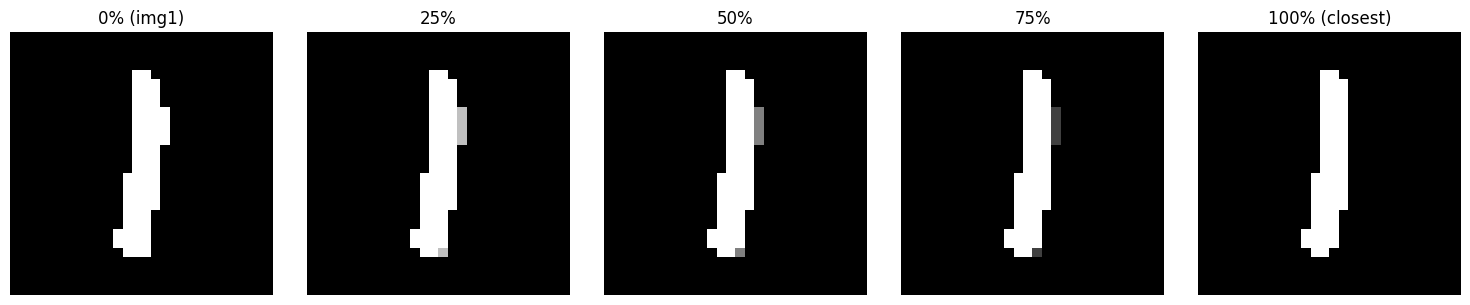

In [102]:
import random
import torch
import matplotlib.pyplot as plt

# Randomly choose a first image from the dataset of 1s
idx1 = random.randint(0, len(mnist_train_ones) - 1)
img1, label1 = mnist_train_ones[idx1]

# Find the closest image to img1 using Euclidean L2 distance
min_distance = float('inf')
closest_img = None
closest_idx = None

for i in range(len(mnist_train_ones)):
    if i == idx1:  # Skip the same image
        continue
    candidate, _ = mnist_train_ones[i]
    # Compute the L2 (Euclidean) distance between img1 and candidate
    distance = torch.dist(img1, candidate, p=2)
    if distance < min_distance:
        min_distance = distance
        closest_img = candidate
        closest_idx = i

print("Minimum Euclidean distance:", min_distance)

# Define interpolation factors (0% and 100% correspond to img1 and closest_img)
factors = [0.0, 0.25, 0.5, 0.75, 1.0]
interpolated_images = []
for t in factors:
    interp_img = (1 - t) * img1 + t * closest_img  # Linear interpolation
    interpolated_images.append(interp_img.view(28, 28))  # Reshape to 28x28 for plotting

# Plot the original images and interpolated results
fig, axs = plt.subplots(1, len(interpolated_images), figsize=(15, 3))
titles = ["0% (img1)", "25%", "50%", "75%", "100% (closest)"]

for ax, img, title in zip(axs, interpolated_images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [103]:
# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")


Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


Estimated number of clusters (excluding noise): 5


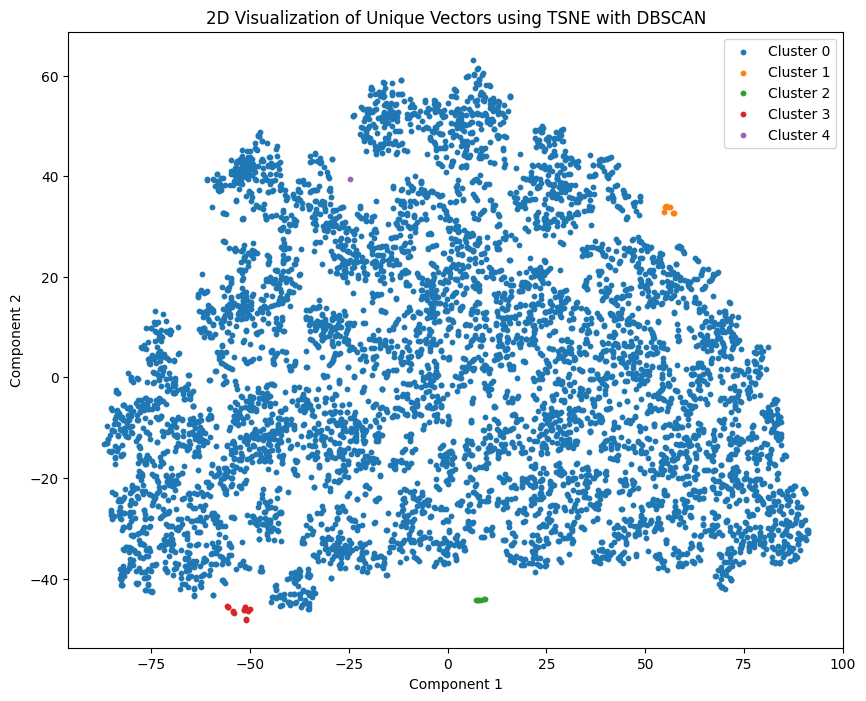

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

def visualize_clusters(unique_vectors, method='tsne', clustering_eps=5.5, clustering_min_samples=5):
    """
    Visualizes clusters among unique_vectors by reducing dimensions to 2D and running DBSCAN.

    Args:
        unique_vectors (torch.Tensor or np.array): Array of shape (n, 784) containing unique images.
        method (str): 'tsne' (default) or 'pca' for dimensionality reduction.
        clustering_eps (float): The DBSCAN eps parameter.
        clustering_min_samples (int): The DBSCAN min_samples parameter.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'cpu'):
        X = unique_vectors.cpu().numpy()
    else:
        X = unique_vectors

    # Dimensionality Reduction to 2D.
    if method.lower() == 'pca':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    X_reduced = reducer.fit_transform(X)

    # Cluster using DBSCAN.
    clustering = DBSCAN(eps=clustering_eps, min_samples=clustering_min_samples)
    labels = clustering.fit_predict(X_reduced)

    # Number of clusters (excluding noise label -1).
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Estimated number of clusters (excluding noise): {n_clusters}")

    # Visualize clusters.
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Set label name; noise is labeled as -1.
        label_name = f'Cluster {label}' if label != -1 else 'Noise'
        idx = labels == label
        plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=label_name, s=10)
    plt.title(f'2D Visualization of Unique Vectors using {method.upper()} with DBSCAN')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

visualize_clusters(unique_vectors, method='tsne', clustering_eps=4, clustering_min_samples=1)


In [105]:
import random
import torch

def ball_cluster(unique_vectors, distance_threshold):
    """
    Clusters the unique 784-d vectors by repeatedly choosing a random center
    and grouping all vectors within the given Euclidean distance.

    Args:
      unique_vectors (torch.Tensor): Tensor of shape (n, 784) with unique images.
      distance_threshold (float): Maximum Euclidean distance for including a vector in a cluster.

    Returns:
      cluster_strings (list of str): List of strings describing each cluster, e.g. "Cluster 0: 12 nodes".
      clusters (list of lists): Each sublist contains the indices of unique_vectors belonging to that cluster.
    """
    clusters = []  # List to hold clusters (each cluster is a list of indices)
    remaining = set(range(unique_vectors.shape[0]))  # All indices that haven't been assigned yet

    while remaining:
        # Randomly choose a center from the remaining indices
        center_idx = random.choice(list(remaining))
        center = unique_vectors[center_idx]

        # Get a list of remaining indices and corresponding candidate vectors
        remaining_list = list(remaining)
        candidates = unique_vectors[remaining_list]  # shape: [num_remaining, 784]

        # Compute Euclidean distances between center and each candidate
        distances = torch.norm(candidates - center, dim=1)

        # Find indices where distance is within threshold
        within_threshold = [remaining_list[i] for i, d in enumerate(distances) if d <= distance_threshold]

        # Add this set as a new cluster
        clusters.append(within_threshold)

        # Remove these indices from the remaining set
        remaining = remaining.difference(within_threshold)

    # Create a string list summarizing each cluster
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i}: {len(cluster)} nodes")

    return clusters

clusters = ball_cluster(unique_vectors, 4)


Cluster 0: 207 nodes
Cluster 1: 67 nodes
Cluster 2: 52 nodes
Cluster 3: 34 nodes
Cluster 4: 116 nodes
Cluster 5: 145 nodes
Cluster 6: 18 nodes
Cluster 7: 44 nodes
Cluster 8: 1 nodes
Cluster 9: 180 nodes
Cluster 10: 53 nodes
Cluster 11: 225 nodes
Cluster 12: 89 nodes
Cluster 13: 30 nodes
Cluster 14: 97 nodes
Cluster 15: 12 nodes
Cluster 16: 24 nodes
Cluster 17: 70 nodes
Cluster 18: 63 nodes
Cluster 19: 76 nodes
Cluster 20: 3 nodes
Cluster 21: 70 nodes
Cluster 22: 196 nodes
Cluster 23: 14 nodes
Cluster 24: 26 nodes
Cluster 25: 92 nodes
Cluster 26: 1 nodes
Cluster 27: 38 nodes
Cluster 28: 37 nodes
Cluster 29: 1 nodes
Cluster 30: 1 nodes
Cluster 31: 31 nodes
Cluster 32: 2 nodes
Cluster 33: 24 nodes
Cluster 34: 1 nodes
Cluster 35: 1 nodes
Cluster 36: 60 nodes
Cluster 37: 1 nodes
Cluster 38: 67 nodes
Cluster 39: 3 nodes
Cluster 40: 1 nodes
Cluster 41: 120 nodes
Cluster 42: 10 nodes
Cluster 43: 42 nodes
Cluster 44: 85 nodes
Cluster 45: 1 nodes
Cluster 46: 95 nodes
Cluster 47: 3 nodes
Cluster 

Building graph for 6726 nodes...
Graph built with 92855 edges.
Computing 2D embedding with t-SNE...


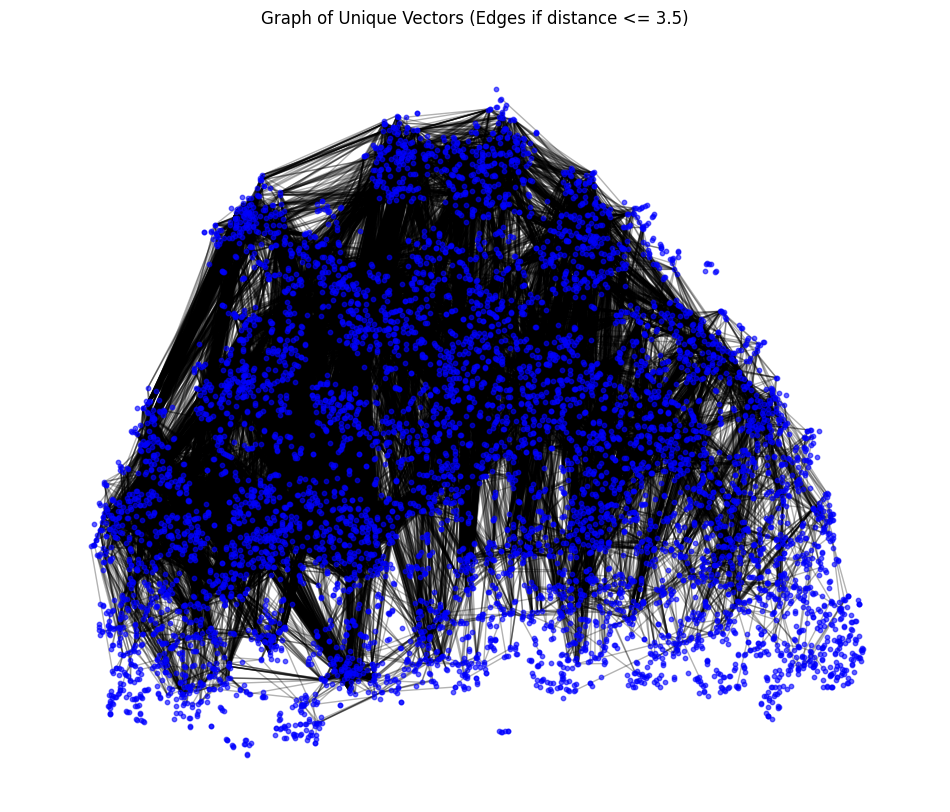

In [106]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import networkx as nx

def visualize_threshold_graph(unique_vectors, distance_threshold):
    """
    Builds and visualizes a graph where each unique vector is a node and an edge is added
    between nodes if their Euclidean distance is <= distance_threshold.

    The visualization uses t-SNE to embed the nodes into 2D (to mimic a Kepler Mapper style).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'cpu'):
        X = unique_vectors.cpu().numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='ball_tree').fit(X)
    # indices[i] is an array of indices of neighbors for node i (including itself)
    distances, indices = nbrs.radius_neighbors(X)

    # Create an undirected graph and add nodes
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Add edges: For each node, add an edge to every neighbor with index > current node (to avoid duplicates)
    for i, neigh in enumerate(indices):
        for j in neigh:
            if i < j:
                G.add_edge(i, j)
    print(f"Graph built with {G.number_of_edges()} edges.")

    # Compute a 2D embedding for visualization using t-SNE.
    print("Computing 2D embedding with t-SNE...")
    X_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
    pos = {i: X_reduced[i] for i in range(n)}

    # Plot the graph
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"Graph of Unique Vectors (Edges if distance <= {distance_threshold})")
    plt.axis('off')
    plt.show()

    return G

G = visualize_threshold_graph(unique_vectors, distance_threshold=3.5)


In [107]:
# # Install PyVis if not already installed (uncomment the next line if needed)
# !pip install pyvis

# # Convert node IDs in G to native Python ints
# def convert_graph_node_ids_to_int(G):
#     H = nx.Graph()
#     # Convert nodes
#     for node, data in G.nodes(data=True):
#         H.add_node(int(node), **data)
#     # Convert edges
#     for u, v, data in G.edges(data=True):
#         H.add_edge(int(u), int(v), **data)
#     return H

# G_int = convert_graph_node_ids_to_int(G)

# # Now visualize using PyVis as before
# from pyvis.network import Network

# def visualize_graph_html(G, output_filename="graph.html", notebook=True):
#     net = Network(notebook=notebook, height="800px", width="100%", bgcolor="#222222", font_color="white")
#     net.from_nx(G)
#     net.show_buttons(filter_=['physics'])
#     net.show(output_filename)

# visualize_graph_html(G_int, output_filename="unique_vectors_graph.html")



In [108]:
# Get all connected components as a list of sets
components = list(nx.connected_components(G))
print(f"Total connected components: {len(components)}")

# Filter components that have more than 5 nodes
large_components = [(i, comp) for i, comp in enumerate(components) if len(comp) > 5]

# Print each large component's index and size
for comp_idx, comp in large_components:
    print(f"Component {comp_idx}: {len(comp)} nodes")


Total connected components: 1142
Component 13: 5493 nodes
Component 270: 6 nodes
Component 492: 7 nodes


In [109]:
# Extract the main component (largest connected component) from G
main_component_nodes = max(nx.connected_components(G), key=len)
G_main = G.subgraph(main_component_nodes)

print(f"Main component has {G_main.number_of_nodes()} nodes and {G_main.number_of_edges()} edges.")

# --- 1. Cycle Basis (Cyclomatic Number) ---
# The cycle basis is a minimal set of cycles from which every cycle in the graph can be formed.
cycle_basis = nx.cycle_basis(G_main)
cyclomatic_number = len(cycle_basis)
print(f"Cyclomatic number (number of independent cycles) in the main component: {cyclomatic_number}")

# --- 2. Maximal Cliques ---
# A clique is a subset of nodes where every two nodes are connected.
# Finding all maximal cliques can be expensive for very large graphs.
print("Computing maximal cliques in the main component (this may take some time)...")
maximal_cliques = list(nx.find_cliques(G_main))
print(f"Number of maximal cliques in the main component: {len(maximal_cliques)}")

# Optionally, if you want to inspect the sizes of the largest cliques:
clique_sizes = [len(clique) for clique in maximal_cliques]
print(f"Max clique size: {max(clique_sizes)}; Average clique size: {np.mean(clique_sizes):.2f}")


Main component has 5493 nodes and 92758 edges.
Cyclomatic number (number of independent cycles) in the main component: 87266
Computing maximal cliques in the main component (this may take some time)...
Number of maximal cliques in the main component: 92477
Max clique size: 65; Average clique size: 14.62


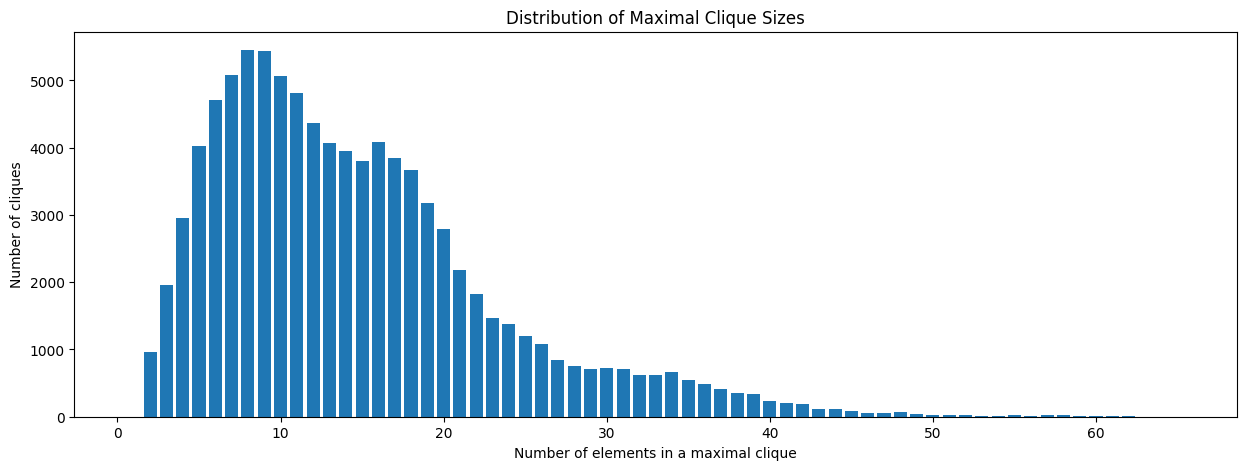

In [110]:
# prompt: make bar graph of how many elements in maximal_cliques have 1 to 65 elements

import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'maximal_cliques' is defined from your previous code
clique_sizes = [len(clique) for clique in maximal_cliques]

# Count the number of cliques with 1 to 65 elements
counts = [0] * 65
for size in clique_sizes:
  if size <= 65:
    counts[size - 1] += 1

# Create a bar graph
plt.figure(figsize=(15, 5))
plt.bar(range(1, 66), counts)
plt.xlabel("Number of elements in a maximal clique")
plt.ylabel("Number of cliques")
plt.title("Distribution of Maximal Clique Sizes")
plt.show()


Sampled 10000 pairwise Jaccard similarities.
Mean similarity: 0.023446687444361205
Median similarity: 0.0
Min similarity: 0.0
Max similarity: 0.9130434782608695


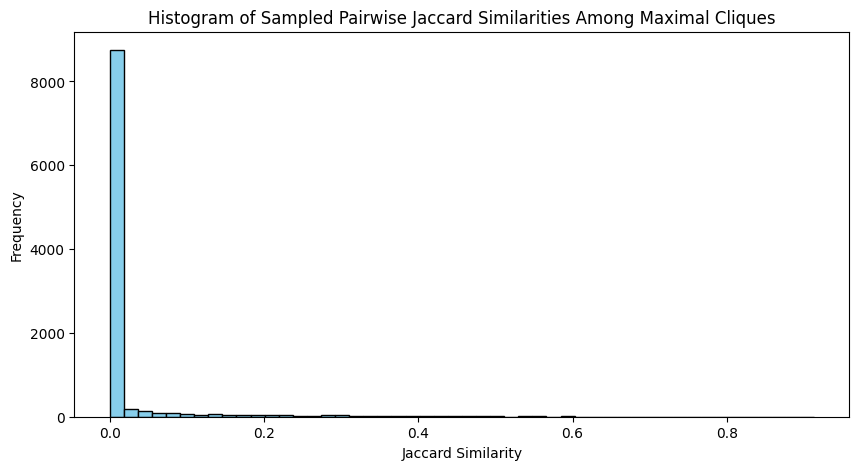

In [111]:
import numpy as np
import random
import matplotlib.pyplot as plt

def jaccard_similarity(clique1, clique2):
    s1 = set(clique1)
    s2 = set(clique2)
    union = s1 | s2
    if not union:
        return 0.0
    return len(s1 & s2) / len(union)

# Number of samples to take
sample_size = 10000
num_cliques = len(maximal_cliques)
similarities = []

# Sample sample_size random pairs (i, j) with i < j
for _ in range(sample_size):
    i = random.randint(0, num_cliques - 2)
    j = random.randint(i + 1, num_cliques - 1)
    sim = jaccard_similarity(maximal_cliques[i], maximal_cliques[j])
    similarities.append(sim)

similarities = np.array(similarities)

print("Sampled", len(similarities), "pairwise Jaccard similarities.")
print("Mean similarity:", similarities.mean())
print("Median similarity:", np.median(similarities))
print("Min similarity:", similarities.min())
print("Max similarity:", similarities.max())

plt.figure(figsize=(10,5))
plt.hist(similarities, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Jaccard Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Sampled Pairwise Jaccard Similarities Among Maximal Cliques")
plt.show()


25% coverage: 37411 cliques used, last clique had 15 nodes, total nodes seen: 1374 out of 5493
50% coverage: 67844 cliques used, last clique had 8 nodes, total nodes seen: 2747 out of 5493
75% coverage: 86567 cliques used, last clique had 5 nodes, total nodes seen: 4120 out of 5493
100% coverage: 92477 cliques used, last clique had 2 nodes, total nodes seen: 5493 out of 5493


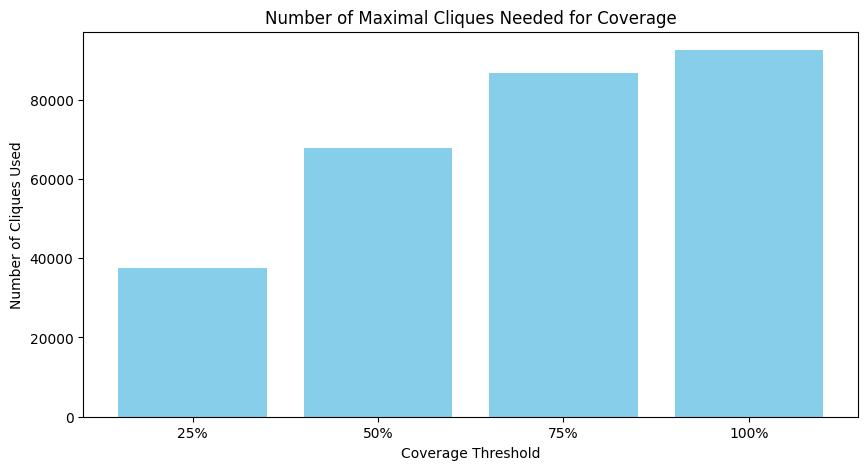

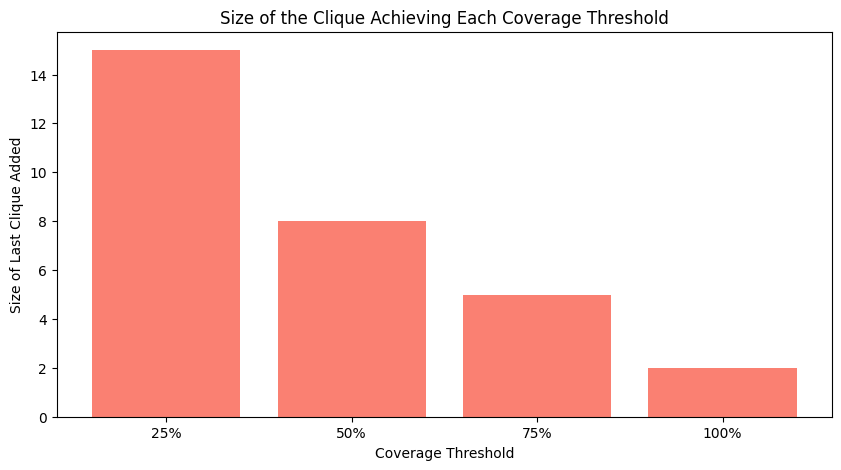

In [112]:
import matplotlib.pyplot as plt
import numpy as np

def record_coverage_by_cliques(maximal_cliques, total_nodes, thresholds=[0.25, 0.50, 0.75, 1.0]):
    """
    Given a list of maximal cliques and the total number of nodes in the component,
    this function sorts the cliques (largest first) and iterates over them, marking
    nodes as "seen." When the cumulative coverage reaches each threshold, it records
    the number of cliques used and the size of the clique that achieved that threshold.

    Args:
        maximal_cliques (list of lists): Each element is a list of node IDs in that clique.
        total_nodes (int): Total number of nodes in the component.
        thresholds (list of floats): Fractions (between 0 and 1) at which to record coverage.

    Returns:
        results (dict): Keys are thresholds (as a fraction) and values are tuples:
                        (num_cliques_used, size_of_last_clique, cumulative_nodes_seen)
    """
    # Sort cliques in descending order by their size
    sorted_cliques = sorted(maximal_cliques, key=lambda clique: len(clique), reverse=True)

    seen = set()
    results = {}
    clique_count = 0

    # Work through thresholds in ascending order for recording
    threshold_targets = sorted(thresholds)

    for clique in sorted_cliques:
        clique_count += 1
        seen.update(clique)
        current_coverage = len(seen)
        current_fraction = current_coverage / total_nodes

        # Record any thresholds that have just been reached or passed
        while threshold_targets and current_fraction >= threshold_targets[0]:
            threshold = threshold_targets.pop(0)
            results[threshold] = (clique_count, len(clique), current_coverage)

        if not threshold_targets:
            break

    return results

# Assuming G_main is your main component subgraph and maximal_cliques were computed from it:
total_nodes = G_main.number_of_nodes()  # total nodes in the main component
results = record_coverage_by_cliques(maximal_cliques, total_nodes)

# Print the results
for threshold in sorted(results.keys()):
    num_cliques, clique_size, seen_nodes = results[threshold]
    print(f"{int(threshold*100)}% coverage: {num_cliques} cliques used, "
          f"last clique had {clique_size} nodes, total nodes seen: {seen_nodes} out of {total_nodes}")

# Optionally, create bar graphs for visualization:
threshold_labels = [f"{int(threshold*100)}%" for threshold in sorted(results.keys())]
num_cliques_list = [results[thr][0] for thr in sorted(results.keys())]
last_clique_sizes = [results[thr][1] for thr in sorted(results.keys())]

plt.figure(figsize=(10, 5))
plt.bar(threshold_labels, num_cliques_list, color='skyblue')
plt.xlabel("Coverage Threshold")
plt.ylabel("Number of Cliques Used")
plt.title("Number of Maximal Cliques Needed for Coverage")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(threshold_labels, last_clique_sizes, color='salmon')
plt.xlabel("Coverage Threshold")
plt.ylabel("Size of Last Clique Added")
plt.title("Size of the Clique Achieving Each Coverage Threshold")
plt.show()


In [113]:
# import numpy as np
# import matplotlib.pyplot as plt

# def jaccard_similarity(clique1, clique2):
#     set1 = set(clique1)
#     set2 = set(clique2)
#     inter = len(set1.intersection(set2))
#     union = len(set1.union(set2))
#     return inter / union if union > 0 else 0

# # Compute pairwise Jaccard similarities between all maximal cliques.
# pairwise_similarities = []
# num_cliques = len(maximal_cliques)
# for i in range(num_cliques):
#     for j in range(i + 1, num_cliques):
#         sim = jaccard_similarity(maximal_cliques[i], maximal_cliques[j])
#         pairwise_similarities.append(sim)

# pairwise_similarities = np.array(pairwise_similarities)
# print(f"Computed {len(pairwise_similarities)} pairwise similarities.")
# print("Min similarity:", pairwise_similarities.min())
# print("Max similarity:", pairwise_similarities.max())
# print("Mean similarity:", pairwise_similarities.mean())
# print("Median similarity:", np.median(pairwise_similarities))

# # Plot histogram of the pairwise Jaccard similarities.
# plt.figure(figsize=(10, 5))
# plt.hist(pairwise_similarities, bins=50, color='skyblue', edgecolor='black')
# plt.xlabel("Jaccard Similarity")
# plt.ylabel("Frequency")
# plt.title("Histogram of Pairwise Jaccard Similarities Among Maximal Cliques")
# plt.show()


In [114]:
# import numpy as np
# import random
# import matplotlib.pyplot as plt

# def jaccard_similarity(clique1, clique2):
#     set1 = set(clique1)
#     set2 = set(clique2)
#     inter = len(set1.intersection(set2))
#     union = len(set1.union(set2))
#     return inter / union if union > 0 else 0

# # Subsample a fixed number of pairs instead of computing all pairs.
# sample_size = 10000  # Adjust this number as needed.
# num_cliques = len(maximal_cliques)
# pairwise_similarities = []

# # Ensure there are enough pairs available.
# max_possible_pairs = num_cliques * (num_cliques - 1) // 2
# if sample_size > max_possible_pairs:
#     sample_size = max_possible_pairs

# # Weighted sampling of clique pairs based on size
# weights = [len(c) for c in maximal_cliques]
# for _ in range(sample_size):
#     i = random.choices(range(num_cliques), weights=weights, k=1)[0]
#     j = random.choices(range(num_cliques), weights=weights, k=1)[0]
#     if i != j:
#         sim = jaccard_similarity(maximal_cliques[i], maximal_cliques[j])
#         pairwise_similarities.append(sim)


# pairwise_similarities = np.array(pairwise_similarities)
# print(f"Computed {len(pairwise_similarities)} pairwise similarities (sampled).")
# print("Min similarity:", pairwise_similarities.min())
# print("Max similarity:", pairwise_similarities.max())
# print("Mean similarity:", pairwise_similarities.mean())
# print("Median similarity:", np.median(pairwise_similarities))

# # Plot histogram of the sampled pairwise Jaccard similarities.
# plt.figure(figsize=(10, 5))
# plt.hist(pairwise_similarities, bins=50, color='skyblue', edgecolor='black')
# plt.xlabel("Jaccard Similarity")
# plt.ylabel("Frequency")
# plt.title("Histogram of Sampled Pairwise Jaccard Similarities Among Maximal Cliques")
# plt.show()


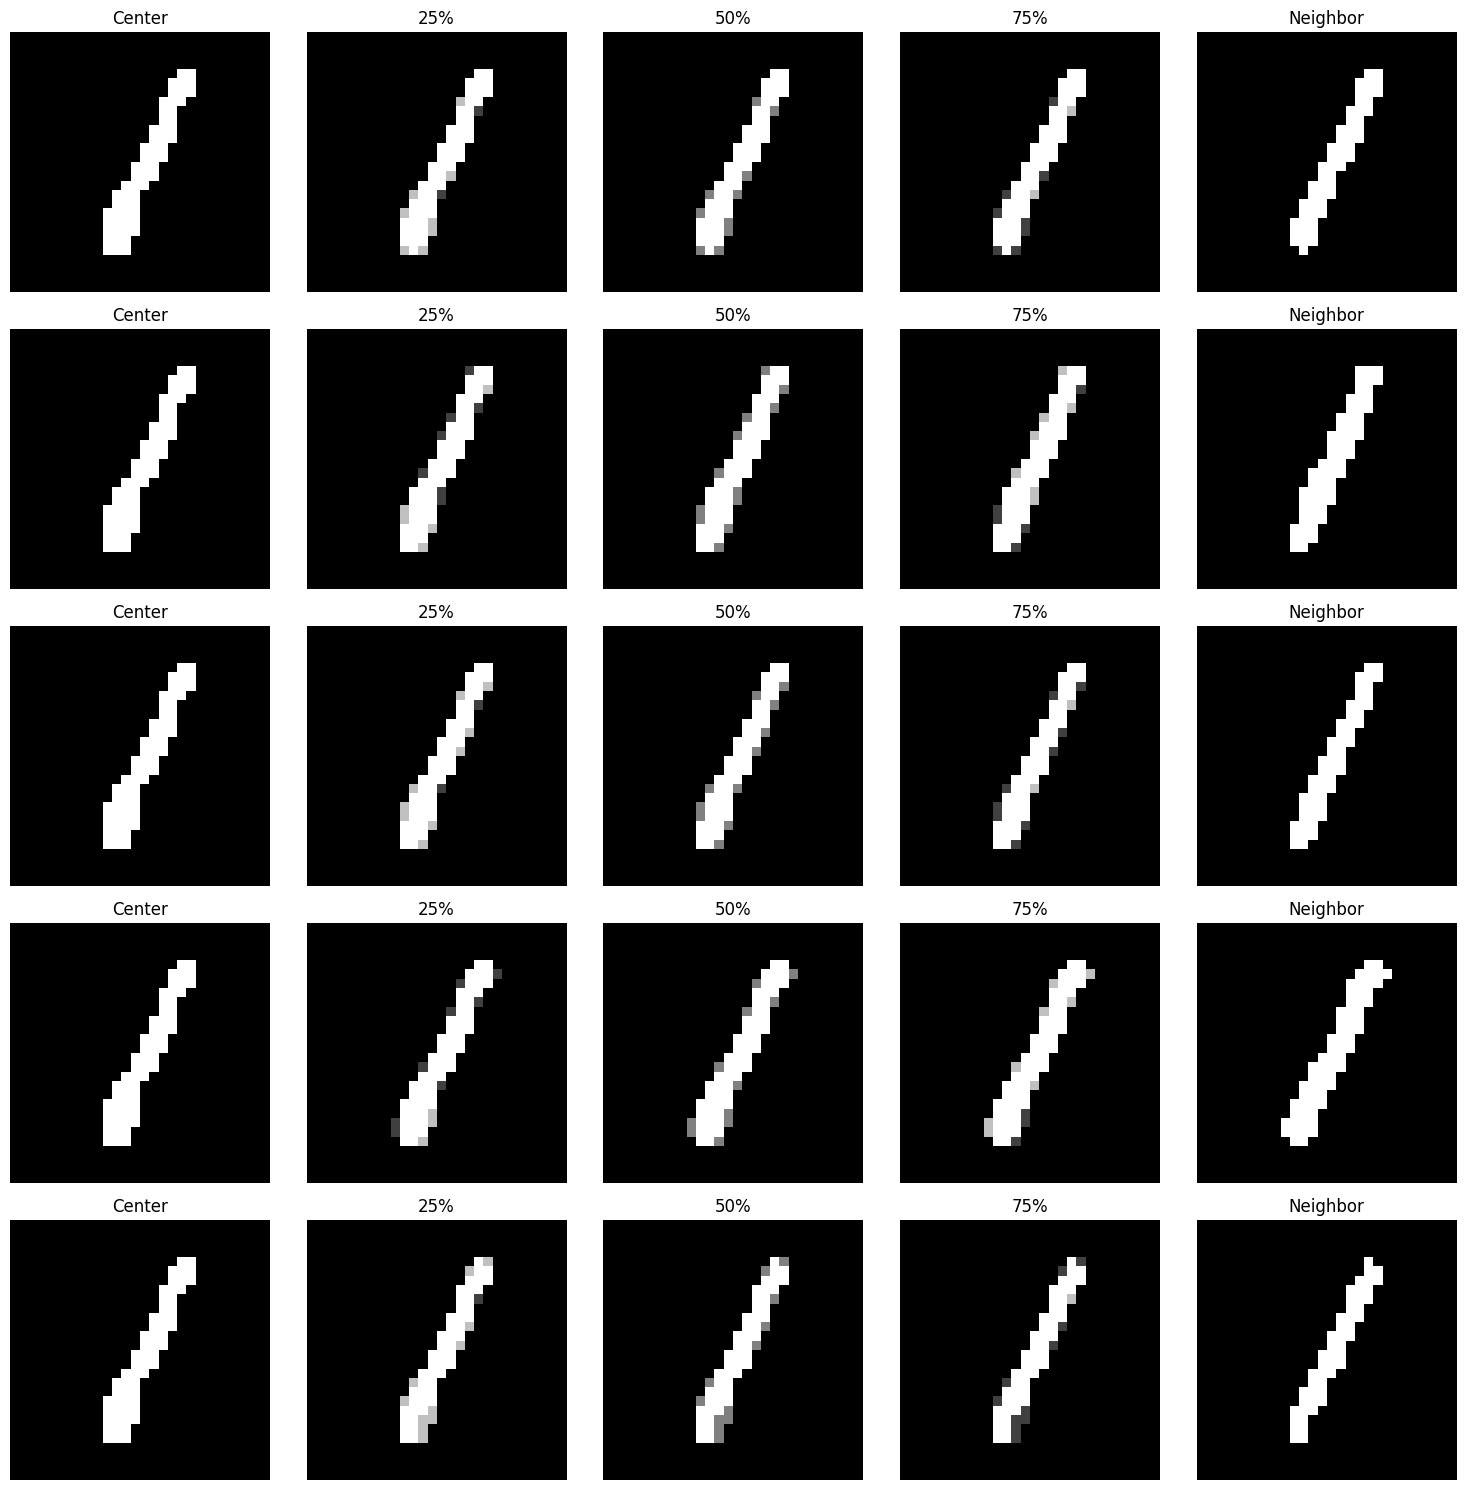

In [115]:
import random
import matplotlib.pyplot as plt
import torch

# Assume G (the graph) and unique_vectors (tensor of shape [n, 784]) are defined

# Get all connected components and select component 13 (as printed previously)
components = list(nx.connected_components(G))
# Option 1: Use the 14th component in the list (index 13)
component_13 = list(components[13])
# Alternatively, if not sure, you could choose the largest component:
# component_13 = list(max(components, key=len))

# Randomly choose one node from component 13 as the center
center_node = random.choice(component_13)

# Get neighbors of the center node
neighbors = list(G.neighbors(center_node))
if len(neighbors) < 5:
    selected_neighbors = neighbors  # if fewer than 5, use them all
else:
    selected_neighbors = random.sample(neighbors, 5)

# Get the center image from unique_vectors and reshape to 28x28
center_image = unique_vectors[center_node]
center_image_reshaped = center_image.view(28, 28)

# Interpolation factors to use
factors = [0.25, 0.5, 0.75]

# Prepare a plot: one row per selected neighbor, each row has 5 images
num_rows = len(selected_neighbors)
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# If only one row, force axs to be 2D for consistent indexing
if num_rows == 1:
    axs = [axs]

for row, neighbor in enumerate(selected_neighbors):
    neighbor_image = unique_vectors[neighbor]
    neighbor_image_reshaped = neighbor_image.view(28, 28)

    # Compute interpolated images
    interpolated_images = []
    for t in factors:
        interp_img = (1 - t) * center_image + t * neighbor_image
        interpolated_images.append(interp_img.view(28, 28))

    # Plot each row:
    # Column 0: the center image
    axs[row][0].imshow(center_image_reshaped, cmap='gray')
    axs[row][0].set_title("Center")
    axs[row][0].axis('off')

    # Columns 1-3: interpolated images at 25%, 50%, 75%
    for j, interp_img in enumerate(interpolated_images, start=1):
        axs[row][j].imshow(interp_img, cmap='gray')
        axs[row][j].set_title(f"{int(factors[j-1]*100)}%")
        axs[row][j].axis('off')

    # Column 4: the neighbor image
    axs[row][4].imshow(neighbor_image_reshaped, cmap='gray')
    axs[row][4].set_title("Neighbor")
    axs[row][4].axis('off')

plt.tight_layout()
plt.show()


Biggest clique has 65 nodes


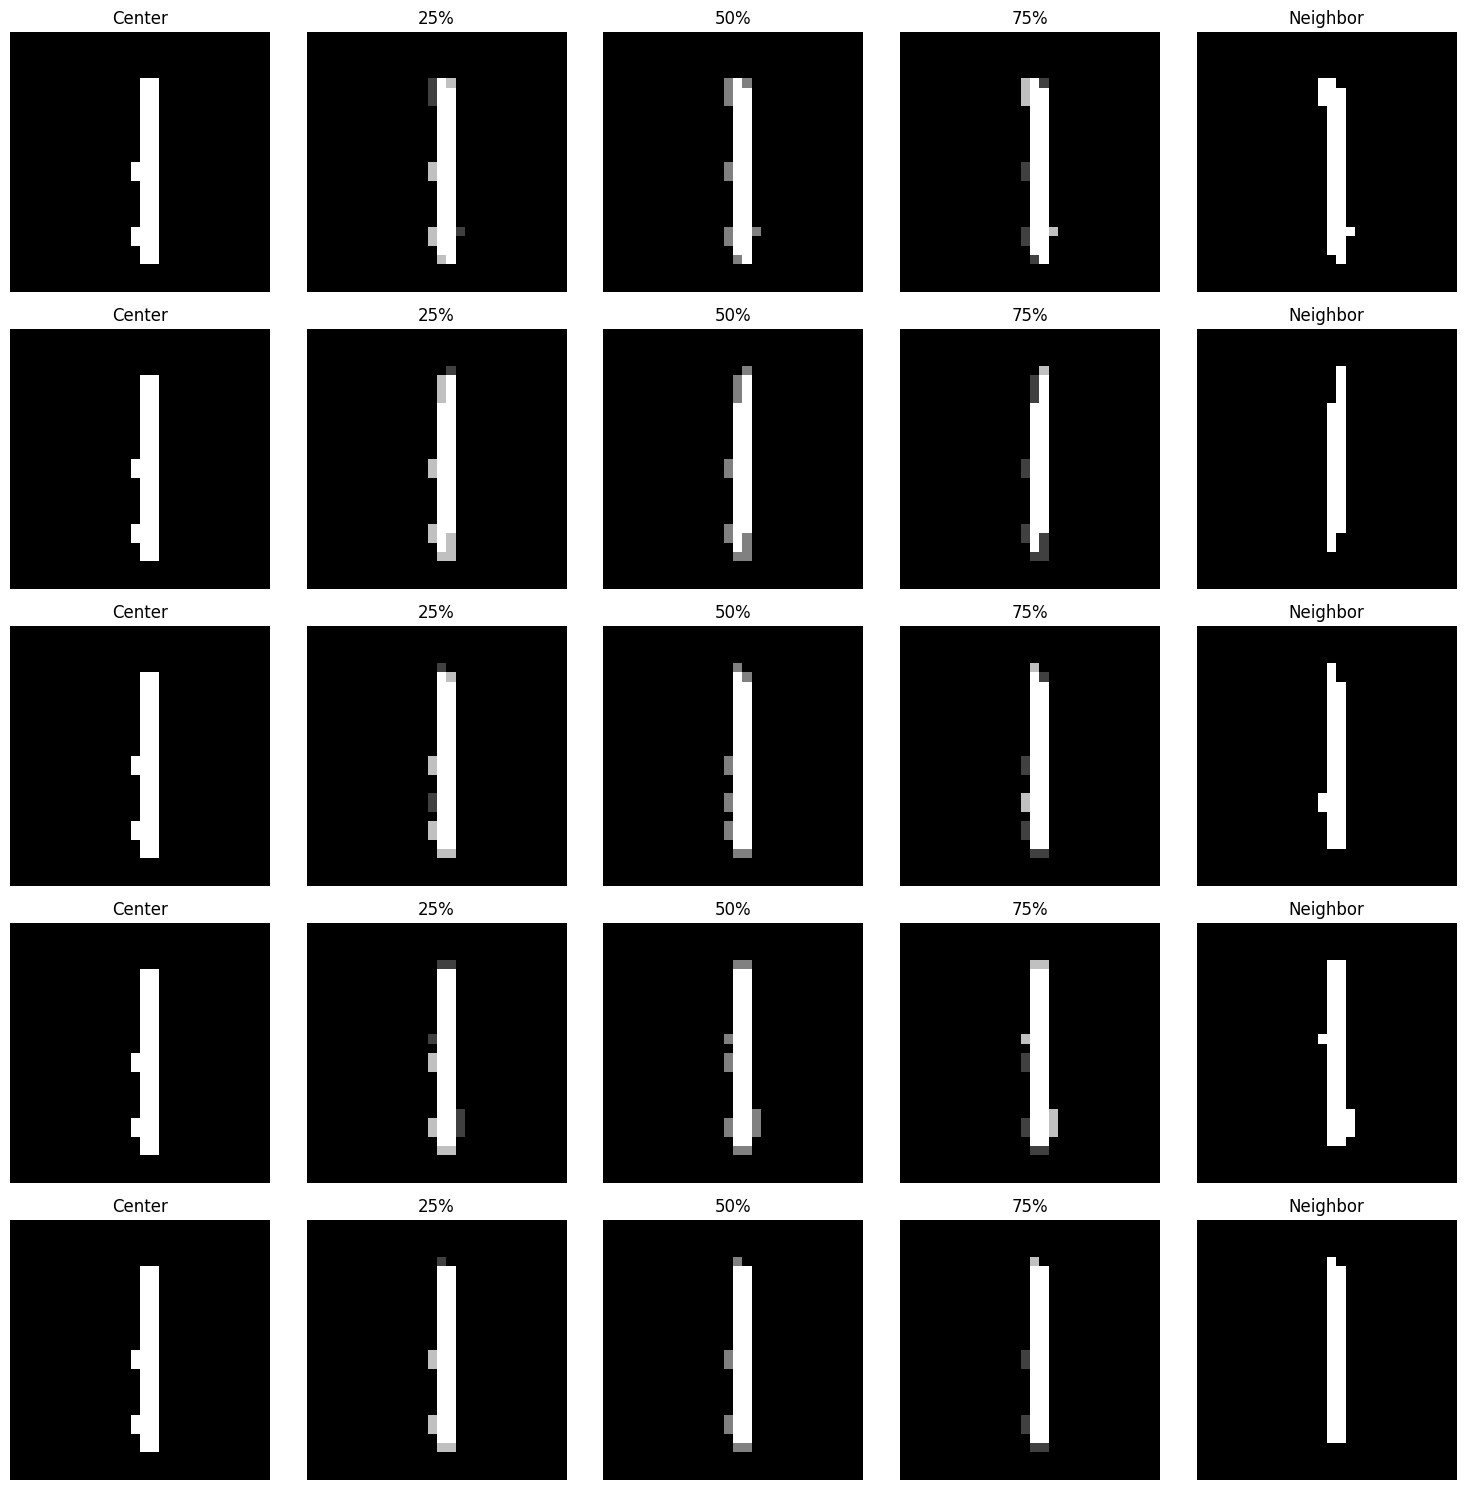

In [116]:
import random
import matplotlib.pyplot as plt
import torch

# --- Step 1: Get the biggest maximal clique ---
biggest_clique = max(maximal_cliques, key=len)
print(f"Biggest clique has {len(biggest_clique)} nodes")

# Ensure biggest_clique is a list (if not already)
biggest_clique = list(biggest_clique)

# --- Step 2: Randomly choose a center node from the biggest clique ---
center_node = random.choice(biggest_clique)
center_image = unique_vectors[center_node]
center_image_reshaped = center_image.view(28, 28)

# --- Step 3: Randomly sample up to 5 neighbors from the clique (excluding the center) ---
neighbors = [node for node in biggest_clique if node != center_node]
if len(neighbors) < 5:
    sampled_neighbors = neighbors
else:
    sampled_neighbors = random.sample(neighbors, 5)

# --- Step 4: For each neighbor, compute 25%, 50%, and 75% interpolations ---
factors = [0.25, 0.5, 0.75]
num_rows = len(sampled_neighbors)
num_cols = 5  # Columns: Center, 25%, 50%, 75%, Neighbor

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# If there's only one row, ensure axs is 2D for consistent indexing
if num_rows == 1:
    axs = [axs]

for row, neighbor in enumerate(sampled_neighbors):
    neighbor_image = unique_vectors[neighbor]
    neighbor_image_reshaped = neighbor_image.view(28, 28)

    # Compute interpolated images
    interpolated_images = []
    for t in factors:
        interp_img = (1 - t) * center_image + t * neighbor_image
        interpolated_images.append(interp_img.view(28, 28))

    # --- Step 5: Plot the images in one row ---
    # Column 0: Center image
    axs[row][0].imshow(center_image_reshaped, cmap='gray')
    axs[row][0].set_title("Center")
    axs[row][0].axis('off')

    # Columns 1-3: Interpolated images at 25%, 50%, 75%
    for j, interp_img in enumerate(interpolated_images, start=1):
        axs[row][j].imshow(interp_img, cmap='gray')
        axs[row][j].set_title(f"{int(factors[j-1]*100)}%")
        axs[row][j].axis('off')

    # Column 4: Neighbor image
    axs[row][4].imshow(neighbor_image_reshaped, cmap='gray')
    axs[row][4].set_title("Neighbor")
    axs[row][4].axis('off')

plt.tight_layout()
plt.show()


Biggest clique has 65 nodes.
Pairwise distance matrix (Euclidean distances):
tensor([[0.0000, 2.6458, 2.6458,  ..., 3.0000, 3.0000, 3.3166],
        [2.6458, 0.0000, 2.0000,  ..., 2.4495, 2.8284, 2.0000],
        [2.6458, 2.0000, 0.0000,  ..., 2.8284, 2.8284, 2.8284],
        ...,
        [3.0000, 2.4495, 2.8284,  ..., 0.0000, 3.4641, 3.1623],
        [3.0000, 2.8284, 2.8284,  ..., 3.4641, 0.0000, 3.1623],
        [3.3166, 2.0000, 2.8284,  ..., 3.1623, 3.1623, 0.0000]])


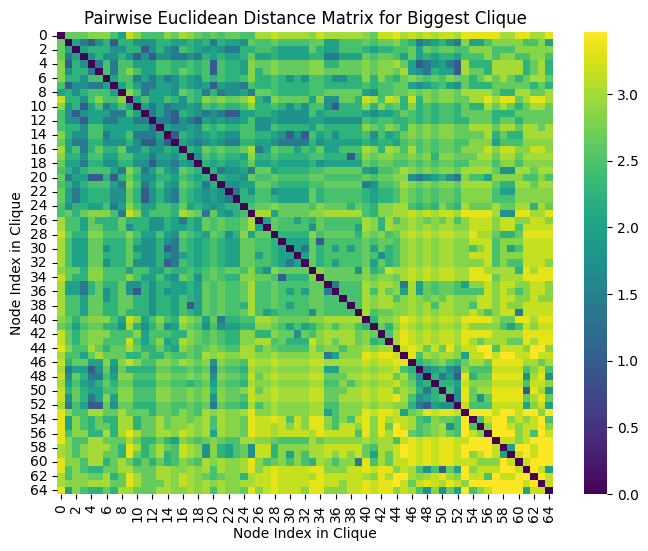

In [117]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'biggest_clique' is defined as the list of indices of nodes in the largest maximal clique,
# and 'unique_vectors' is a tensor of shape [n, 784] containing the vectors for all nodes.

# Extract the vectors corresponding to the biggest clique.
clique_indices = biggest_clique  # already a list of indices
clique_vectors = unique_vectors[clique_indices]  # shape: [num_points, 784]
num_points = clique_vectors.shape[0]
print(f"Biggest clique has {num_points} nodes.")

# Compute the pairwise Euclidean distance matrix.
# Using torch.cdist is efficient even for our small clique (65 nodes).
distance_matrix = torch.cdist(clique_vectors, clique_vectors, p=2)

print("Pairwise distance matrix (Euclidean distances):")
print(distance_matrix)

# Optional: Visualize the distance matrix as a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix.cpu().numpy(), cmap='viridis', annot=False)
plt.title("Pairwise Euclidean Distance Matrix for Biggest Clique")
plt.xlabel("Node Index in Clique")
plt.ylabel("Node Index in Clique")
plt.show()


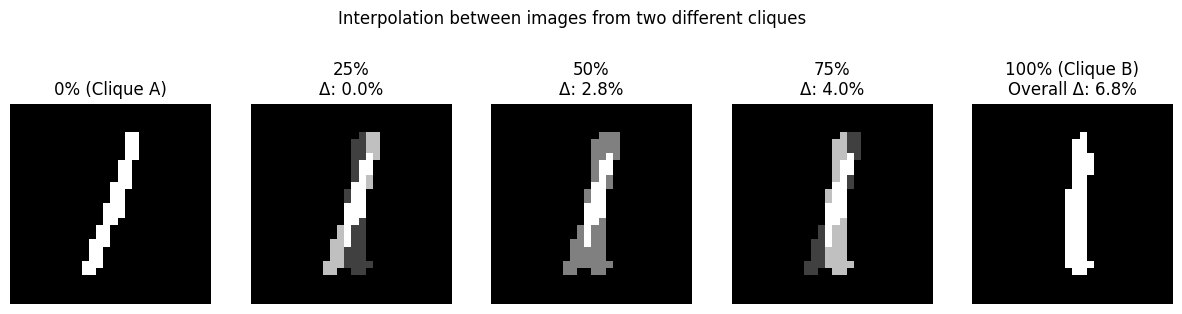

Overall, 6.8% of pixels differ between the two endpoint images.


In [118]:
import random
import torch
import matplotlib.pyplot as plt

# --- Step 1: Pick two different maximal cliques and then one image from each.
if len(maximal_cliques) < 2:
    raise ValueError("Need at least 2 cliques to pick from.")

# Randomly sample 2 distinct cliques
clique_A, clique_B = random.sample(maximal_cliques, 2)

# Pick one random node from each clique
img1_idx = random.choice(clique_A)
img2_idx = random.choice(clique_B)

img1 = unique_vectors[img1_idx]
img2 = unique_vectors[img2_idx]

# --- Step 2: Interpolate between the two images with factors 0, 0.25, 0.5, 0.75, 1.0.
factors = [0.0, 0.25, 0.5, 0.75, 1.0]
interpolated_images = []
for t in factors:
    interp_img = (1 - t) * img1 + t * img2
    interpolated_images.append(interp_img.view(28, 28))

# --- Step 3: Define a helper to threshold images (convert to binary).
def threshold_image(img, threshold=0.5):
    # Given our images are (mostly) binary, we threshold them.
    return (img > threshold).float()

# --- Step 4: Calculate the percentage of pixel differences between consecutive images.
pixel_diffs = []
for i in range(len(interpolated_images) - 1):
    bin_img1 = threshold_image(interpolated_images[i])
    bin_img2 = threshold_image(interpolated_images[i+1])
    diff = (bin_img1 != bin_img2).sum().item()
    total_pixels = bin_img1.numel()
    percent_diff = (diff / total_pixels) * 100
    pixel_diffs.append(percent_diff)

# Also compute overall percentage difference between the two endpoints.
bin_img1_end = threshold_image(img1.view(28, 28))
bin_img2_end = threshold_image(img2.view(28, 28))
overall_diff = (bin_img1_end != bin_img2_end).sum().item()
overall_percent_diff = (overall_diff / bin_img1_end.numel()) * 100

# --- Step 5: Plot the interpolation images with titles showing percentage differences.
num_cols = len(interpolated_images)
fig, axs = plt.subplots(1, num_cols, figsize=(15, 4))

for i, img in enumerate(interpolated_images):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    if i == 0:
        title_str = "0% (Clique A)"
    elif i == num_cols - 1:
        title_str = f"100% (Clique B)\nOverall Δ: {overall_percent_diff:.1f}%"
    else:
        title_str = f"{int(factors[i]*100)}%\nΔ: {pixel_diffs[i-1]:.1f}%"
    axs[i].set_title(title_str)

plt.suptitle("Interpolation between images from two different cliques")
plt.show()

print(f"Overall, {overall_percent_diff:.1f}% of pixels differ between the two endpoint images.")


In [119]:
# def greedy_minimal_clique_cover(maximal_cliques, universe):
#     """
#     Compute an approximate minimal clique cover using a greedy heuristic.

#     Args:
#         maximal_cliques (list of lists): Each sublist is a maximal clique (list of node IDs).
#         universe (set): Set of nodes (IDs) that must be covered.

#     Returns:
#         cover (list of lists): A list of cliques chosen to cover the universe.
#     """
#     cover = []
#     remaining = set(universe)  # Nodes that are not yet covered

#     # Keep selecting cliques until all nodes are covered
#     while remaining:
#         # Choose the clique that covers the largest number of remaining nodes.
#         best_clique = max(maximal_cliques, key=lambda clique: len(set(clique) & remaining))
#         cover.append(best_clique)
#         # Remove the nodes covered by the chosen clique from the remaining set.
#         remaining -= set(best_clique)

#     return cover

# # For example, suppose we want to cover all nodes in our main component.
# # Assuming G_main is your main component subgraph.
# universe = set(G_main.nodes())

# # Compute the greedy minimal clique cover.
# clique_cover = greedy_minimal_clique_cover(maximal_cliques, universe)

# print(f"Greedy minimal clique cover uses {len(clique_cover)} cliques to cover {len(universe)} nodes.")
# for i, clique in enumerate(clique_cover):
#     print(f"Clique {i}: covers {len(clique)} nodes")


In [120]:
# Precompute a mapping from node to the set of maximal clique indices it belongs to.
node_to_cliques = {}
for i, clique in enumerate(maximal_cliques):
    for node in clique:
        node_to_cliques.setdefault(node, set()).add(i)

# Count the number of bridge edges in G.
bridge_count = 0
for u, v in G.edges():
    if u in node_to_cliques and v in node_to_cliques and node_to_cliques[u].isdisjoint(node_to_cliques[v]):
        bridge_count += 1

print("Number of bridge edges:", bridge_count)


Number of bridge edges: 0


so to summarize what ive done i have 784d vectors of mnist 1s. i connected the graph based on each vector being a node and having an edge to each node within a certain euclidean distance of other nodes. then picked the biggest connected component of this graph. found the cliques which means collections of nodes that are all less than threshold distance to each other. when i have a bridge edge this means find an edge between 2 nodes that do not share a clique. 2 nodes only share an edge if they are within the threshold of each other. cliques are groups who are all connected meaning less than threshold distance to each other. so if 2 nodes have an edge they must be less than threshold distance and that in and of itself would create a clique of size 2

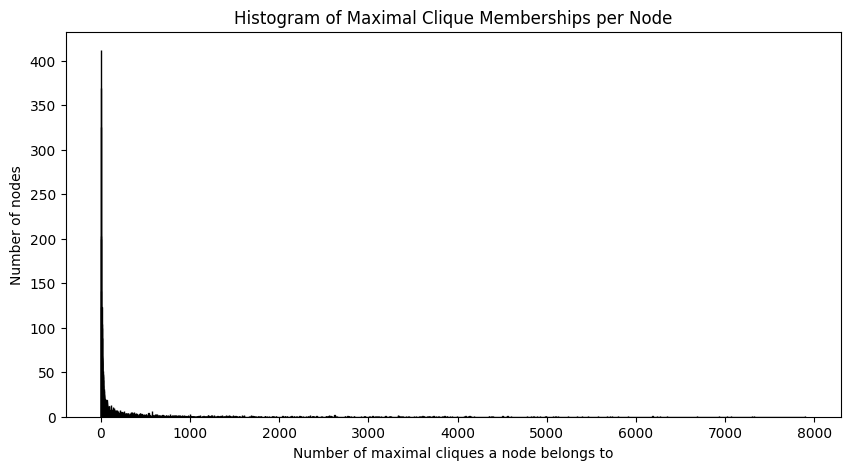

In [121]:
import matplotlib.pyplot as plt

# Compute membership counts for each node (i.e., number of maximal cliques each node belongs to)
membership_counts = [len(cliques) for cliques in node_to_cliques.values()]

# Plot the histogram
plt.figure(figsize=(10, 5))
# Create bins from 1 to max(membership_counts)+1 (so each integer value gets its own bin)
plt.hist(membership_counts, bins=range(1, max(membership_counts) + 2),
         color='skyblue', edgecolor='black', align='left')
plt.xlabel("Number of maximal cliques a node belongs to")
plt.ylabel("Number of nodes")
plt.title("Histogram of Maximal Clique Memberships per Node")
# plt.xticks(range(1, max(membership_counts) + 1))
plt.show()


In [122]:
# prompt: find avg length of clique_to_cliques

import numpy as np

# Assuming clique_to_cliques is defined as in the provided code
# Calculate the average length of the values in the clique_to_cliques dictionary
avg_length = np.median([len(value) for value in clique_to_cliques.values()])
print("Average length of clique_to_cliques:", avg_length)


Average length of clique_to_cliques: 4631.0


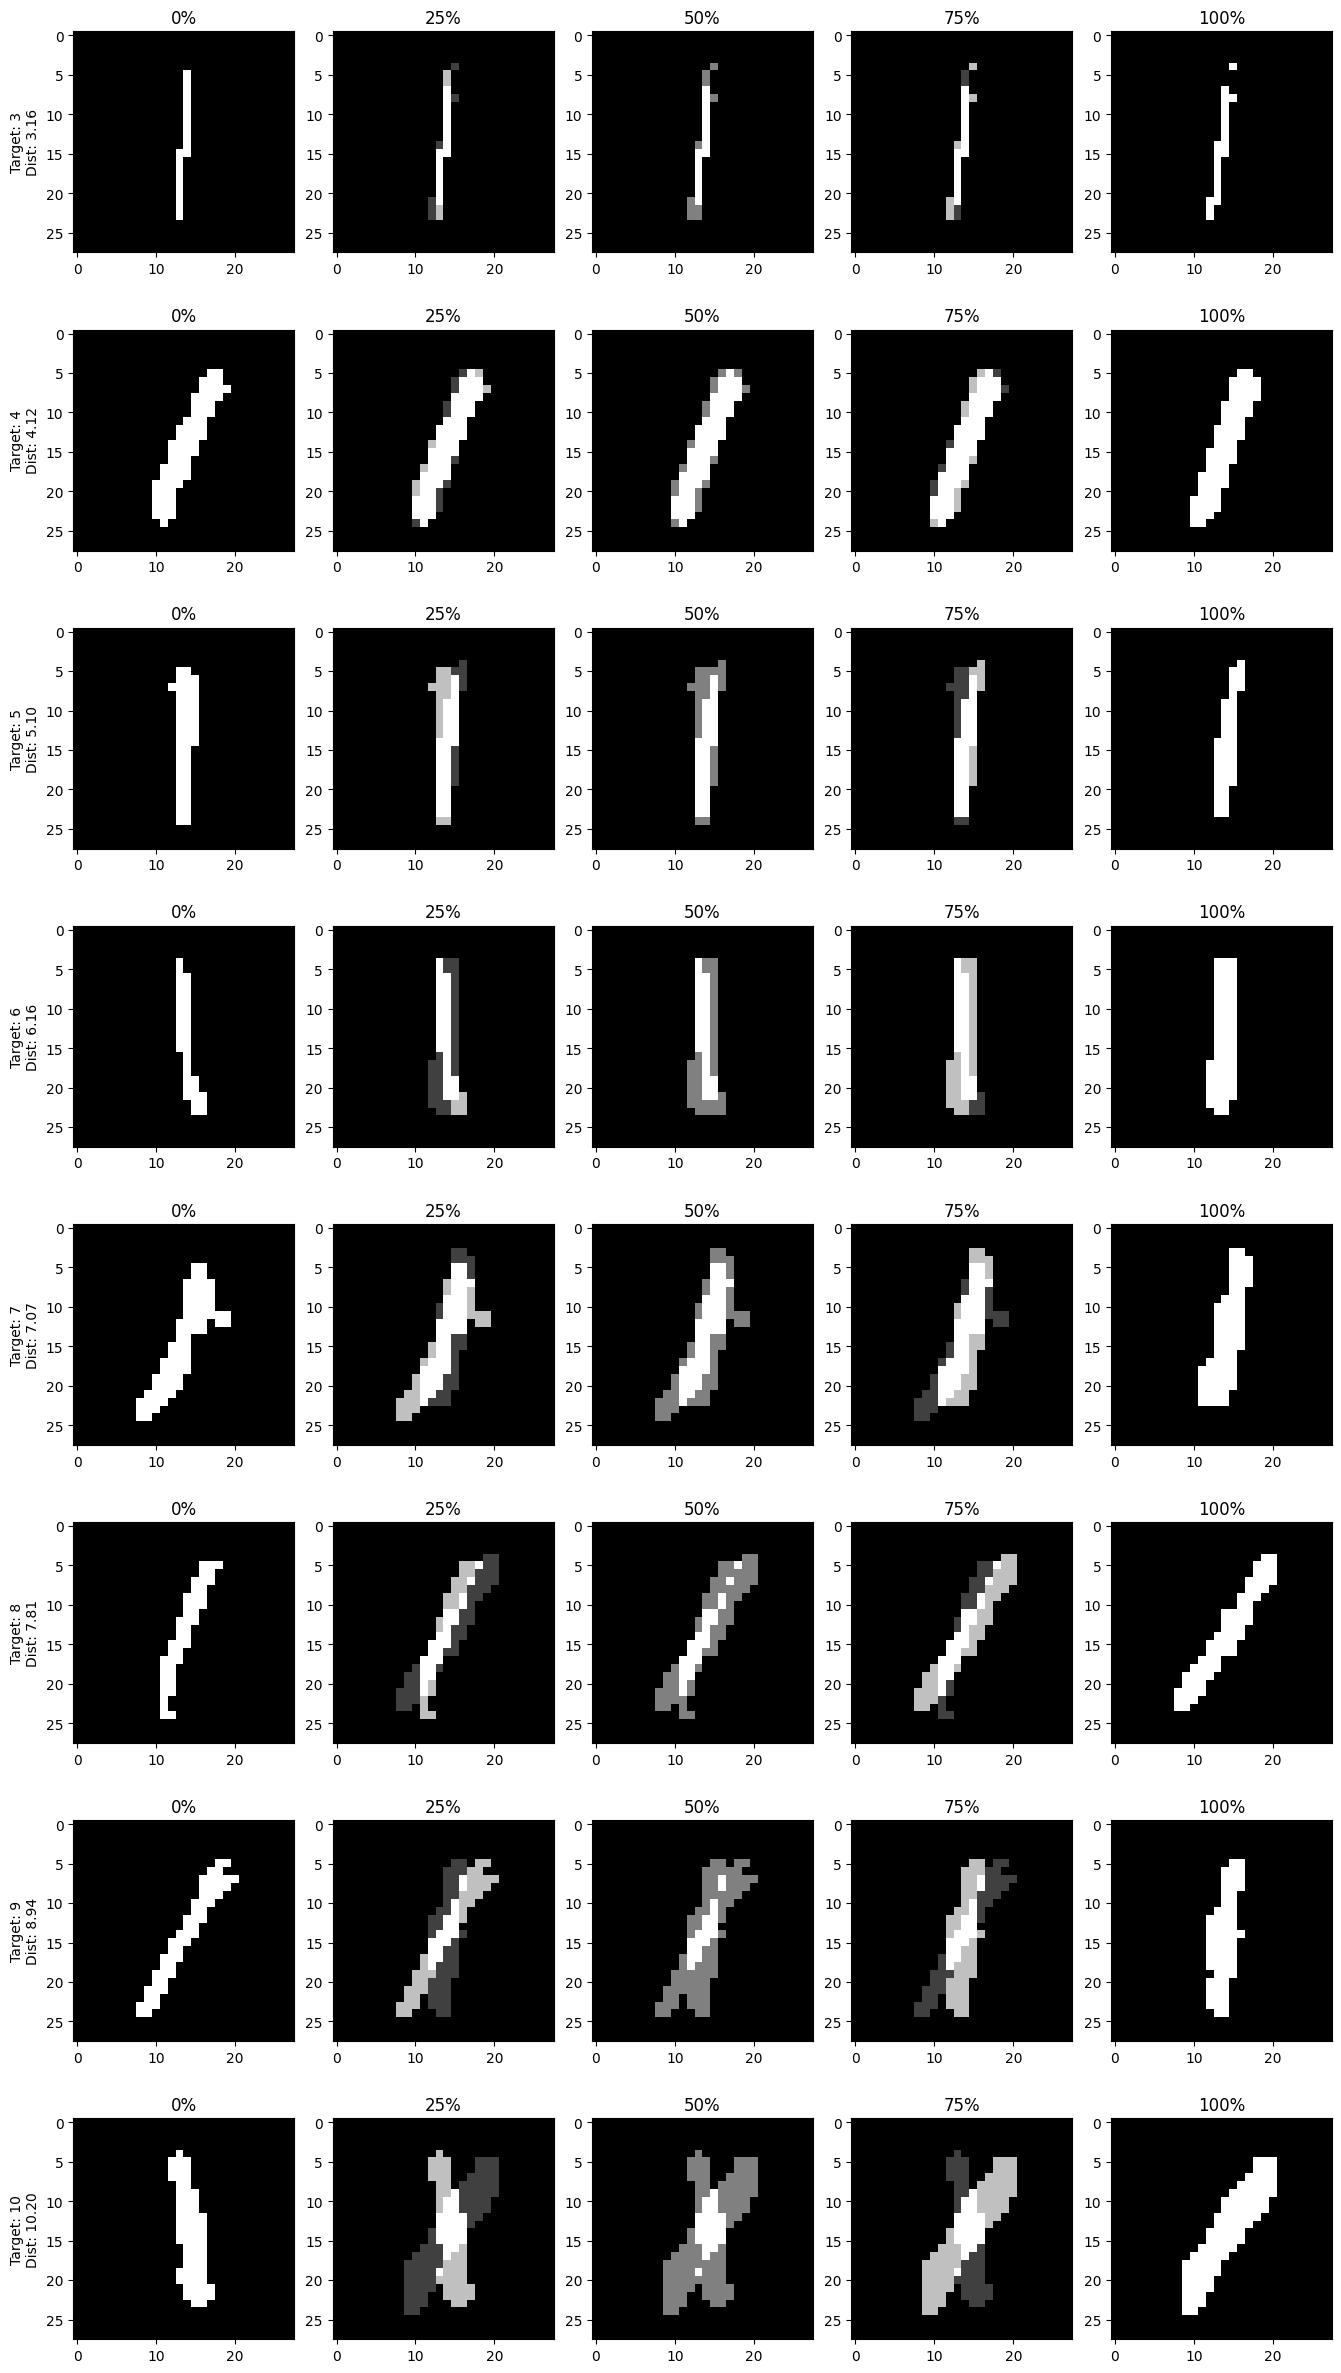

In [123]:
import random
import torch
import matplotlib.pyplot as plt

def find_pair_with_distance(vectors, target_distance, tolerance=0.2, max_tries=10000):
    """
    Randomly samples pairs of vectors until one is found whose Euclidean distance
    is within tolerance of target_distance.

    Args:
        vectors (torch.Tensor): Tensor of shape (n, 784).
        target_distance (float): The desired Euclidean distance.
        tolerance (float): Acceptable deviation.
        max_tries (int): Maximum number of random pairs to try.

    Returns:
        (i, j, d) tuple where i and j are indices and d is the distance,
        or (None, None, None) if no pair was found.
    """
    n = vectors.shape[0]
    for _ in range(max_tries):
        i = random.randint(0, n - 1)
        j = random.randint(0, n - 1)
        if i == j:
            continue
        d = torch.dist(vectors[i], vectors[j], p=2).item()
        if abs(d - target_distance) < tolerance:
            return i, j, d
    return None, None, None

# Define target distances you want to investigate.
target_distances = [3, 4, 5, 6, 7, 8, 9, 10]
factors = [0.0, 0.25, 0.5, 0.75, 1.0]

# List to store results: each item is (target, found_distance, list_of_interpolated_images)
results = []
for target in target_distances:
    i, j, d = find_pair_with_distance(unique_vectors, target, tolerance=0.2)
    if i is None:
        print(f"Could not find a pair for target distance {target}")
        continue
    interp_images = []
    for t in factors:
        # Linear interpolation between endpoints.
        interp = (1 - t) * unique_vectors[i] + t * unique_vectors[j]
        # If your vectors are binary (or thresholded), you might want to threshold them
        # e.g., interp = (interp > 0.5).float()
        interp_images.append(interp.view(28, 28).cpu().numpy())
    results.append((target, d, interp_images))

# Plot each row: one row per target distance.
num_rows = len(results)
num_cols = len(factors)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

for row_idx, (target, d, images) in enumerate(results):
    for col_idx, img in enumerate(images):
        axs[row_idx, col_idx].imshow(img, cmap='gray')
        # axs[row_idx, col_idx].axis('off')
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f"Target: {target}\nDist: {d:.2f}", fontsize=10)
        axs[row_idx, col_idx].set_title(f"{int(factors[col_idx]*100)}%")
plt.tight_layout(rect=[0.1, 0, 1, 1])  # Leaves more space on the left
plt.show()


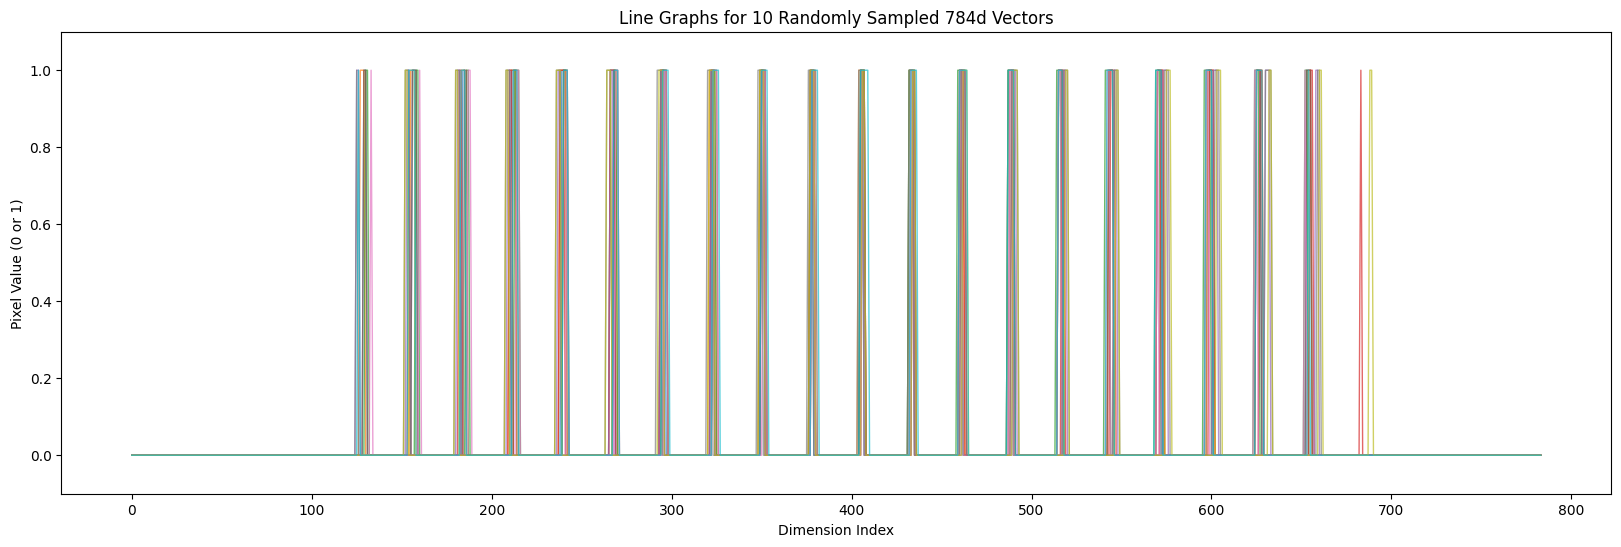

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_sampled_line_graphs(vectors, num_samples=10):
    """
    Randomly sample num_samples vectors from a set of 784-dimensional vectors,
    then plot each as a line graph where the x-axis represents the dimension index
    (0 to 783) and the y-axis is the pixel value (0 or 1).

    Args:
        vectors (torch.Tensor or np.array): Array of shape (n, 784) containing your vectors.
        num_samples (int): Number of random vectors to sample and plot.
    """
    # Convert to numpy array if needed.
    if hasattr(vectors, 'cpu'):
        X = vectors.cpu().numpy()
    else:
        X = np.array(vectors)

    n, dims = X.shape
    sample_indices = random.sample(range(n), min(num_samples, n))

    plt.figure(figsize=(20, 6))
    x_axis = np.arange(dims)  # dimensions 0 to 783

    for idx in sample_indices:
        # Each vector is binary (0 or 1); plot as a line graph.
        y_values = X[idx]
        plt.plot(x_axis, y_values, alpha=0.7, lw=1)

    plt.xlabel("Dimension Index")
    plt.ylabel("Pixel Value (0 or 1)")
    plt.title(f"Line Graphs for {num_samples} Randomly Sampled 784d Vectors")
    plt.ylim(-0.1, 1.1)
    plt.show()

# Example usage:
plot_sampled_line_graphs(unique_vectors, num_samples=10)


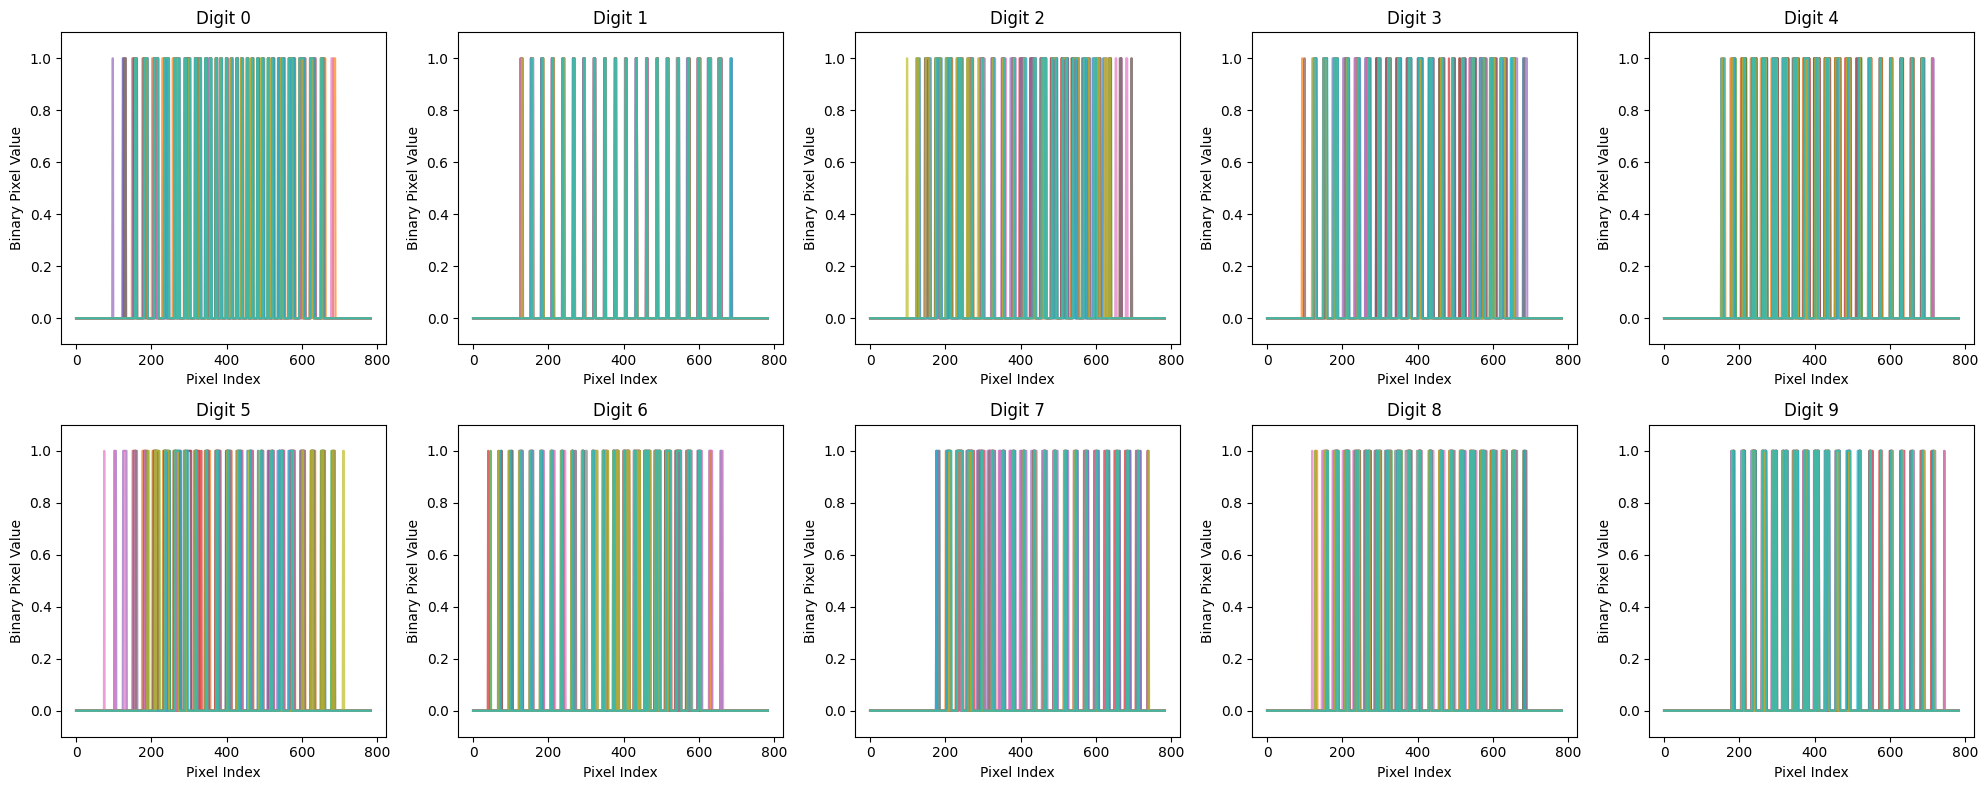

In [126]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

def plot_digit_line_graphs_threshold(dataset, num_samples=10, threshold=0.5):
    """
    For each digit (0-9) in the dataset, randomly sample num_samples
    784-dimensional vectors (flattened images) and threshold them so that
    each pixel becomes 0 or 1. Then plot these as line graphs.

    Args:
      dataset: A PyTorch dataset (e.g., torchvision.datasets.MNIST) with
               attributes .data and .targets.
      num_samples (int): Number of images per digit to sample.
      threshold (float): Threshold value (e.g., 0.5) for binarizing the pixel values.
    """
    # Extract data and labels.
    # For MNIST, dataset.data is typically shape (n, 28, 28) and dataset.targets is shape (n,)
    data = dataset.data
    labels = dataset.targets

    # Convert data to float if needed.
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data)
    data = data.float()

    # If the data is in the 0-255 range, normalize to 0-1.
    if data.max() > 1:
        data = data / 255.0

    n = data.shape[0]
    # Flatten the images if needed: from (n, 28, 28) to (n, 784)
    if len(data.shape) > 2:
        data = data.view(n, -1)

    # Convert data and labels to NumPy arrays.
    data_np = data.cpu().numpy() if data.device.type == 'cuda' else data.numpy()
    labels = labels.cpu().numpy() if isinstance(labels, torch.Tensor) and labels.device.type == 'cuda' else np.array(labels)

    # Threshold the data to obtain binary images.
    binary_data = (data_np > threshold).astype(np.int32)

    # Create a subplot grid: 2 rows x 5 columns for digits 0 through 9.
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()
    x_axis = np.arange(binary_data.shape[1])  # Dimensions: 0 to 783

    for digit in range(10):
        # Get indices for this digit.
        indices = np.where(labels == digit)[0]
        if len(indices) == 0:
            continue

        # Randomly sample indices for this digit.
        sample_indices = random.sample(list(indices), min(num_samples, len(indices)))
        ax = axs[digit]
        for idx in sample_indices:
            # Plot the binary vector as a line graph.
            ax.plot(x_axis, binary_data[idx], alpha=0.7)
        ax.set_title(f"Digit {digit}")
        ax.set_xlabel("Pixel Index")
        ax.set_ylabel("Binary Pixel Value")
        ax.set_ylim([-0.1, 1.1])

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have loaded the MNIST training set as mnist_train (e.g., using torchvision.datasets.MNIST)
plot_digit_line_graphs_threshold(mnist_train, num_samples=10, threshold=0.5)


Building graph for 6726 nodes...
Graph built with 4681902 edges.
Computing 2D embedding with t-SNE...


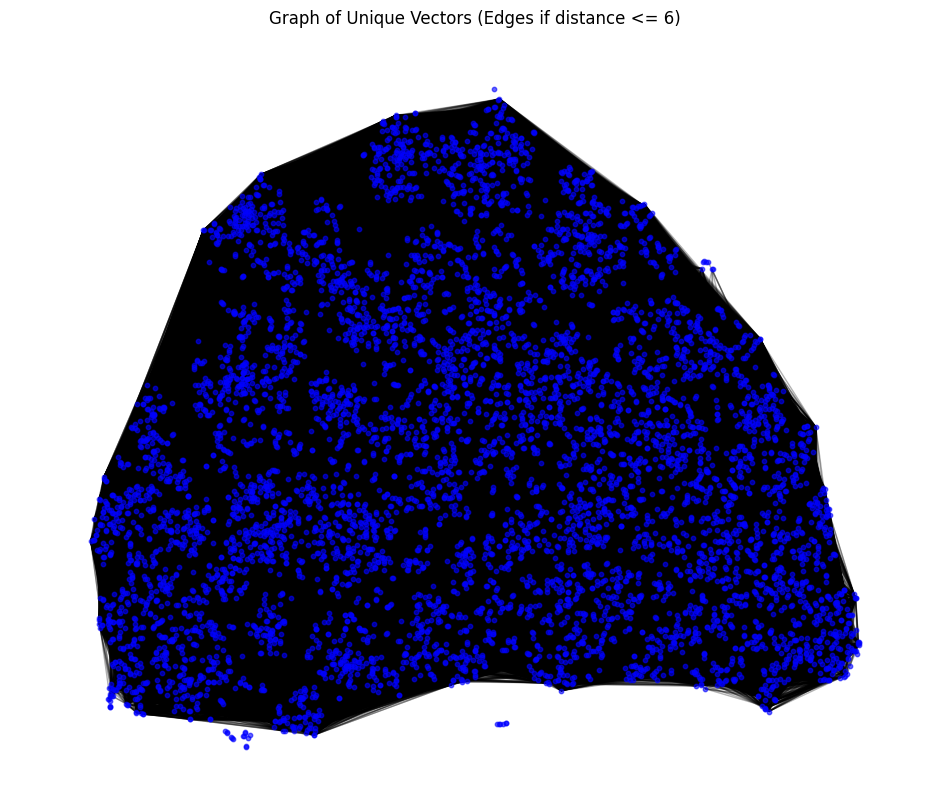

In [124]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import networkx as nx

def visualize_threshold_graph(unique_vectors, distance_threshold):
    """
    Builds and visualizes a graph where each unique vector is a node and an edge is added
    between nodes if their Euclidean distance is <= distance_threshold.

    The visualization uses t-SNE to embed the nodes into 2D (to mimic a Kepler Mapper style).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'cpu'):
        X = unique_vectors.cpu().numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='ball_tree').fit(X)
    # indices[i] is an array of indices of neighbors for node i (including itself)
    distances, indices = nbrs.radius_neighbors(X)

    # Create an undirected graph and add nodes
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Add edges: For each node, add an edge to every neighbor with index > current node (to avoid duplicates)
    for i, neigh in enumerate(indices):
        for j in neigh:
            if i < j:
                G.add_edge(i, j)
    print(f"Graph built with {G.number_of_edges()} edges.")

    # Compute a 2D embedding for visualization using t-SNE.
    print("Computing 2D embedding with t-SNE...")
    X_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
    pos = {i: X_reduced[i] for i in range(n)}

    # Plot the graph
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"Graph of Unique Vectors (Edges if distance <= {distance_threshold})")
    plt.axis('off')
    plt.show()

    return G

G = visualize_threshold_graph(unique_vectors, distance_threshold=6)


In [135]:
# prompt: ouput sorted list of connected components by size of nodes in G

def sort_connected_components(graph):
    """
    Sorts connected components of a graph by the number of nodes in each component.

    Args:
        graph (nx.Graph): The input graph.

    Returns:
        list: A list of connected components, sorted in descending order by size.
              Each component is a list of node IDs.
    """
    connected_components = list(nx.connected_components(graph))
    sorted_components = sorted(connected_components, key=len, reverse=True)
    return sorted_components

# Example usage: Assuming 'G' is your graph
sorted_ccs = sort_connected_components(G)

# Print the sorted connected components and their sizes
for i, component in enumerate(sorted_ccs):
    print(f"Connected Component {i+1}: Size = {len(component)}")


Connected Component 1: Size = 6631
Connected Component 2: Size = 4
Connected Component 3: Size = 3
Connected Component 4: Size = 2
Connected Component 5: Size = 2
Connected Component 6: Size = 2
Connected Component 7: Size = 2
Connected Component 8: Size = 1
Connected Component 9: Size = 1
Connected Component 10: Size = 1
Connected Component 11: Size = 1
Connected Component 12: Size = 1
Connected Component 13: Size = 1
Connected Component 14: Size = 1
Connected Component 15: Size = 1
Connected Component 16: Size = 1
Connected Component 17: Size = 1
Connected Component 18: Size = 1
Connected Component 19: Size = 1
Connected Component 20: Size = 1
Connected Component 21: Size = 1
Connected Component 22: Size = 1
Connected Component 23: Size = 1
Connected Component 24: Size = 1
Connected Component 25: Size = 1
Connected Component 26: Size = 1
Connected Component 27: Size = 1
Connected Component 28: Size = 1
Connected Component 29: Size = 1
Connected Component 30: Size = 1
Connected Compon

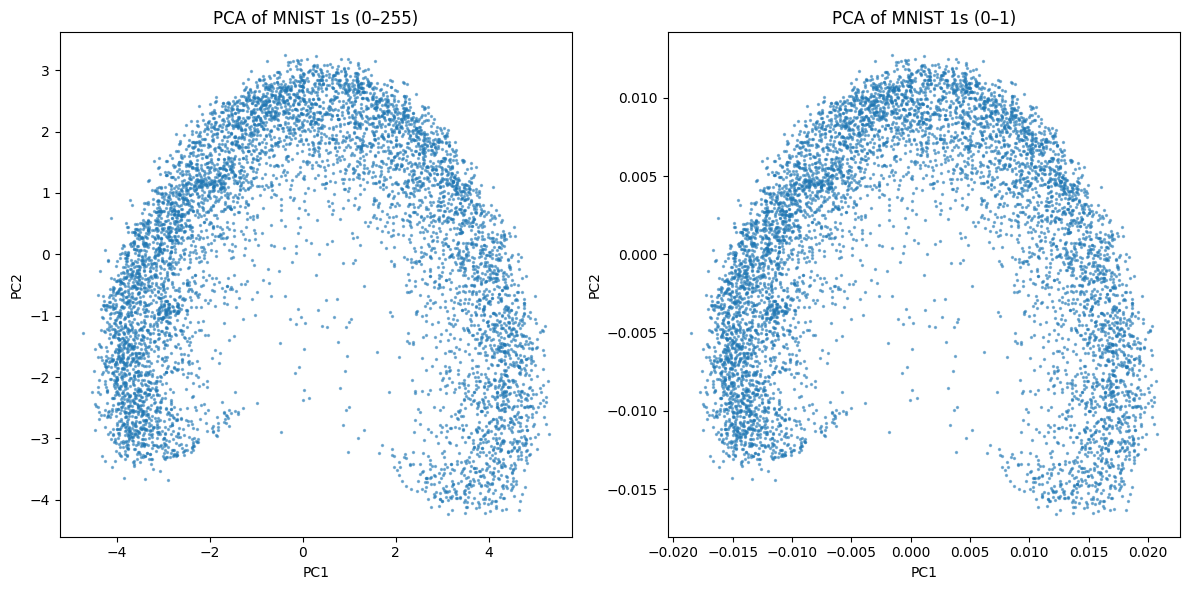

In [136]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_comparison(vectors, title, num_components=2):
    """
    Reduces the 784-dimensional data to num_components using PCA and plots a scatter plot.
    """
    pca = PCA(n_components=num_components)
    reduced = pca.fit_transform(vectors)
    plt.scatter(reduced[:, 0], reduced[:, 1], s=2, alpha=0.5)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

# Assume unique_vectors is a NumPy array of shape (n, 784) with values between 0 and 255.
# Plot for raw data (0–255):
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_pca_comparison(unique_vectors, "PCA of MNIST 1s (0–255)")

# Normalize the data to 0–1.
unique_vectors_norm = unique_vectors / 255.0
plt.subplot(1, 2, 2)
plot_pca_comparison(unique_vectors_norm, "PCA of MNIST 1s (0–1)")
plt.tight_layout()
plt.show()
